In [29]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [174]:
nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }
ccdnamenumdict_inv = {aa: bb for bb, aa in ccdnamenumdict.items()}

fringe_norm_dict = {1: 1.074, 2: 1.500, 3: 1.010, 4: 1.120, 5: 1.080, 6: 1.130, 7: 1.023, 
8: 1.016, 9: 1.018, 10: 0.943, 11: 1.000, 12: 1.000, 13: 1.002, 14: 1.030, 15: 1.040, 
16: 1.244, 17: 1.019, 18: 1.082, 19: 0.951, 20: 0.979, 21: 0.958, 22: 0.948, 23: 0.971, 
24: 1.113, 25: 0.950, 26: 0.956, 27: 0.963, 28: 0.998, 29: 0.960, 30: 0.986, 32: 1.058, 
33: 0.943, 34: 0.992, 35: 0.974, 36: 0.949, 37: 1.015, 38: 1.031, 39: 1.042, 40: 1.028, 
41: 0.944, 42: 0.938, 43: 0.978, 44: 1.112, 45: 1.039, 46: 0.916, 47: 0.997, 48: 0.883, 
49: 1.019, 50: 1.017, 51: 1.016, 52: 1.009, 53: 1.007, 54: 0.950, 55: 0.913, 56: 1.084, 
57: 0.785, 58: 0.946, 59: 0.981, 60: 1.049, 62: 1.024}

fringe_old_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
fringe_new_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/DECam_CP-Fringe-Normed'
image_dir = '/global/project/projectdirs/cosmo/staging/'
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'
surveyccd_path = '/global/homes/r/rongpu/mydesi/dr9/fringe/misc/survey-ccds-decam-dr9-z-band-only-trim.fits'
blob_dir = '/global/cscratch1/sd/rongpu/fringe/decam_ccd_blob_mask'

# frgscale_dir = '/global/cscratch1/sd/rongpu/fringe/tmp_frgscale/'
frgscale_dir = '/global/cscratch1/sd/rongpu/fringe/frgscale/'

# image_output_dir = '/global/cscratch1/sd/rongpu/fringe/fringe_corrected_image/'
image_output_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/temp/'
# image_output_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/fringe/fringe_corrected_image'

In [147]:
# Load CCD list
ccd_columns = ['image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'ccd_cuts']
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
# ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z' # include only z-band images
ccd = ccd[mask]
# print(len(ccd))
ccd['ccdnum'] = [ccdnamenumdict[ccd['ccdname'][ii].strip()] for ii in range(len(ccd))]

expnum_list = np.unique(ccd['expnum'])

# Find the exposures that have the fringe scales computed
expnum_list_done = np.zeros(len(expnum_list), dtype=bool)
for index, expnum in enumerate(expnum_list):
    # Find an arbitrary CCD in the exposure to get the image filename
    ccd_index = np.where((ccd['expnum']==expnum))[0][0]
    frgscale_output_path = os.path.join(frgscale_dir, ccd['image_filename'][ccd_index].strip().replace('.fits.fz', '.txt'))
    # Check that the file exist and not empty
    if os.path.isfile(frgscale_output_path) and (os.stat(frgscale_output_path).st_size != 0):
        expnum_list_done[index] = True
print(np.sum(expnum_list_done), np.sum(~expnum_list_done), np.sum(expnum_list_done)/len(expnum_list_done))

expnum_list = expnum_list[expnum_list_done]
print(len(expnum_list))

18854 165 0.991324465009
18854


In [148]:
# Load old fringe image
fringe_old_dict = {}
for ccdnum in range(1, 63):
    # skip N30 and S7
    if ccdnum==61 or ccdnum==31:
        continue
    fringe_old_path = os.path.join(fringe_old_dir, 'DES17B_20180103_908c062-z-{}_frg.fits'.format(str(ccdnum).zfill(2)))
    fringe_old = fits.getdata(fringe_old_path)
    # remove the edge pixels
    fringe_old = fringe_old[1:4095, 1:2047]
    fringe_old_dict[ccdnum] = fringe_old.copy()

# Load new fringe images
fringe_new_dict = {}
for ccdnum in range(1, 63):
    # skip N30 and S7
    if ccdnum==61 or ccdnum==31:
        continue
    fringe_path = glob.glob(os.path.join(fringe_new_dir, '*CCD{}.fits'.format(str(ccdnum).zfill(2))))[0]
    fringe_img = fits.getdata(fringe_path)
    fringe_img = fringe_img[1:4095, 1:2047]
    fringe_new_dict[ccdnum] = fringe_img.copy()

In [149]:
expnum = expnum_list[0]

print('expnum:', expnum)

# Find an arbitrary CCD in the exposure to get the image filename
ccd_index = np.where((ccd['expnum']==expnum))[0][0]

frgscale_path = os.path.join(frgscale_dir, ccd['image_filename'][ccd_index].strip().replace('.fits.fz', '.txt'))
img_fn_write = os.path.join(image_output_dir, ccd['image_filename'][ccd_index].strip())
img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index].strip())
print(img_fn_write)

expnum: 232745
/global/project/projectdirs/desi/users/rongpu/dr9/fringe/temp/decam/CP/V4.8.2a/CP20130910/c4d_130911_033840_ooi_z_ls9.fits.fz


In [150]:
image_filename = 'decam/CP/V4.8.2/CP20170305/c4d_170306_094450_ooi_z_ls9.fits.fz'
frgscale_path = os.path.join(frgscale_dir, image_filename.replace('.fits.fz', '.txt'))
img_fn_write = os.path.join(image_output_dir, image_filename)
img_fn = os.path.join(image_dir, image_filename)
print(img_fn_write)

/global/project/projectdirs/desi/users/rongpu/dr9/fringe/temp/decam/CP/V4.8.2/CP20170305/c4d_170306_094450_ooi_z_ls9.fits.fz


In [175]:
if os.path.isfile(img_fn_write):
    print(img_fn_write+' already exists!')

if not os.path.exists(os.path.dirname(img_fn_write)):
    try:
        os.makedirs(os.path.dirname(img_fn_write))
    except:
        pass

try:
    fringe_table = Table.read(frgscale_path, format='ascii.commented_header')
except:
    n_ccd = 0
else:
    fringe_table['frgscale_fit'] = 0. # initialize
    # fringe_table['frgscale_applied'] = 0.
    for ii in range(len(fringe_table)):
        ccdnum = fringe_table['ccdnum'][ii]
        fringe_table['frgscale_fit'][ii] = fringe_table['slope'][ii]/fringe_norm_dict[ccdnum]
    mask = fringe_table['ccdnum']!=2 # exclude S30 from the "good" CCDs
    n_ccd = np.sum(mask)
    frgscale_median = np.median(fringe_table['frgscale_fit'][mask])
    if frgscale_median<0:
        frgscale_median = 0

hdul_r = fitsio.FITS(img_fn, mode='r')
hdul_w = fitsio.FITS(img_fn_write, mode='rw', clobber=True)

if n_ccd<10:
    print('Only {} CCDs available; Fringe correction not performed.'.format(n_ccd))

for hdu_index in range(len(hdul_r)):
    if hdu_index==0:
        hdr = hdul_r[hdu_index].read_header()
        hdul_w.write(data=None, header=hdr)
    else:
        hdr = hdul_r[hdu_index].read_header()        
        img = hdul_r[hdu_index].read()
        ccdname = hdul_r[hdu_index].get_extname().strip()
        ccdnum = ccdnamenumdict[ccdname]
        
        # Back out the exisiting fringe correction
        if 'FRGSCALE' in hdr:
            frgscale_old = hdr['FRGSCALE']
            fringe_old = fringe_old_dict[ccdnum]
            img += fringe_old*frgscale_old
        else:
            hdul_w.write(data=img, header=hdr, extname=ccdname)
            continue

        # require at least 10 CCDs for fringe correction
        if (n_ccd<10) or (frgscale_median==0):
            hdul_w.write(data=img, header=hdr, extname=ccdname)
            continue
            
        fringe_img_new = fringe_new_dict[ccdnum]
        img -= frgscale_median * fringe_img_new
        new_key = {'name':'FRGSCNEW', 'value':frgscale_median, 'comment':'New fringe-correction scale'}
        hdr.add_record(new_key)

        hdul_w.write(data=img, header=hdr, extname=ccdname, compress='rice')

/global/project/projectdirs/desi/users/rongpu/dr9/fringe/temp/decam/CP/V4.8.2/CP20170305/c4d_170306_094450_ooi_z_ls9.fits.fz already exists!


In [152]:
ls -lh '/global/project/projectdirs/cosmo/staging/decam/CP/V4.8.2a/CP20130910/c4d_130911_033840_ooi_z_ls9.fits.fz'

-rw-rw-r-- 1 bweaver cosmo 312M Aug 24 01:00 /global/project/projectdirs/cosmo/staging/decam/CP/V4.8.2a/CP20130910/c4d_130911_033840_ooi_z_ls9.fits.fz


In [153]:
ls -lh '/global/cscratch1/sd/rongpu/fringe/tmp_img/decam/CP/V4.8.2a/CP20130910/c4d_130911_033840_ooi_z_ls9.fits.fz'

-rw-rw---- 1 rongpu desi 312M Feb  4 11:59 /global/cscratch1/sd/rongpu/fringe/tmp_img/decam/CP/V4.8.2a/CP20130910/c4d_130911_033840_ooi_z_ls9.fits.fz


In [182]:
hdu_index = 35
data0 = fits.getdata(img_fn, ext=hdu_index)
data = fits.getdata(img_fn_write, ext=hdu_index)

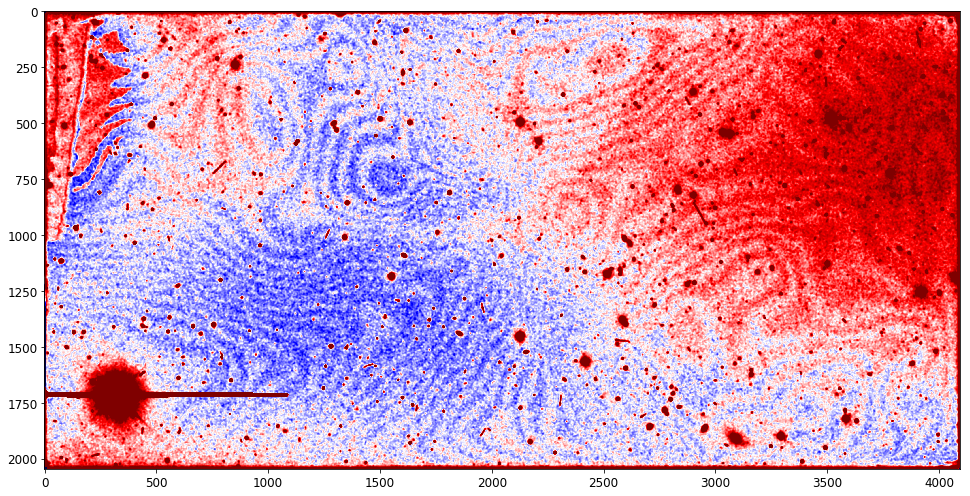

In [183]:
img1 = data0.copy()
img1[~np.isfinite(img1)] = 0
img1 = gaussian_filter(img1, 3, mode='reflect', truncate=3)

plt.figure(figsize=(15, 7))
plt.imshow((img1).T, cmap='seismic', vmin=0.99*np.median(data), vmax=1.008*np.median(data))
plt.tight_layout()
plt.show()

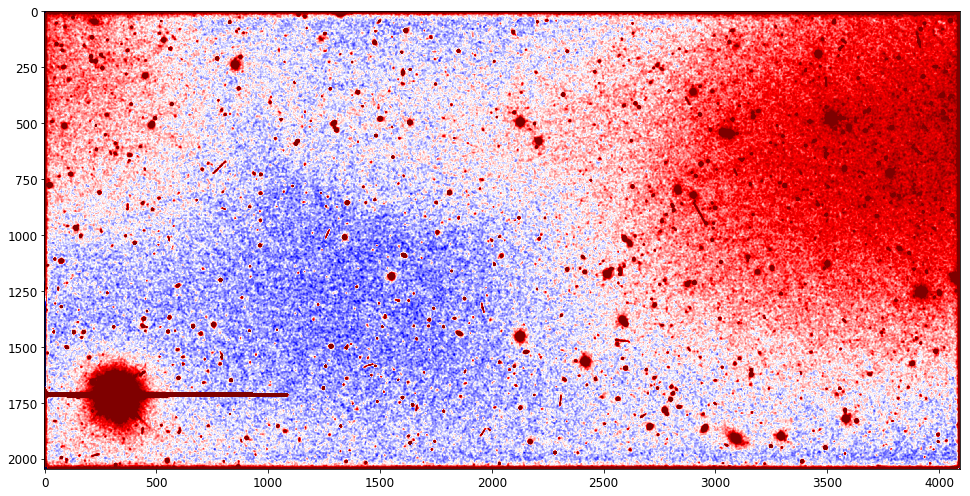

In [184]:
img1 = data.copy()
img1[~np.isfinite(img1)] = 0
img1 = gaussian_filter(img1, 3, mode='reflect', truncate=3)

plt.figure(figsize=(15, 7))
plt.imshow((img1).T, cmap='seismic', vmin=0.99*np.median(data), vmax=1.008*np.median(data))
plt.tight_layout()
plt.show()